In [1]:
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, TimeDistributed, MaxPooling2D, LSTM 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
#from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
import pandas as pd
import cv2
import os

import numpy as np

Using TensorFlow backend.


In [2]:
img_height , img_width = 64, 64
seq_len = 250
 
classes = ["0","1"]

In [3]:
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list

In [4]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [7]:
X, Y = create_data("video_input/")


0
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
1
Defected frame
Defected frame


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

In [9]:
model = Sequential()
model.add(TimeDistributed(Conv2D(64, 5, activation='relu', padding='same', name='conv1'), input_shape=(seq_len, img_height, img_width, 3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='pool1')))

model.add(TimeDistributed(Conv2D(128, 5, activation='relu', name='conv2')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='pool2')))

model.add(TimeDistributed(Conv2D(256, 5, activation='relu', name='conv3')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='pool3')))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))

model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(2, activation='sigmoid'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 250, 64, 64, 64)   4864      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 250, 32, 32, 64)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 250, 28, 28, 128)  204928    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 250, 14, 14, 128)  0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 250, 10, 10, 256)  819456    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 250, 5, 5, 256)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 250, 6400)        

In [10]:
opt = keras.optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [11]:
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]

In [12]:
history = model.fit(x = X_train, y = y_train, epochs=2, batch_size = 1 , shuffle=True, validation_split=0.2, callbacks=callbacks)

Train on 52 samples, validate on 13 samples
Epoch 1/2
52/52 [==============================] - 852s 16s/step - loss: 0.7803 - accuracy: 0.4615 - val_loss: 0.6719 - val_accuracy: 0.5385
Epoch 2/2
52/52 [==============================] - 861s 17s/step - loss: 0.6556 - accuracy: 0.5769 - val_loss: 0.7345 - val_accuracy: 0.2308


In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(2)


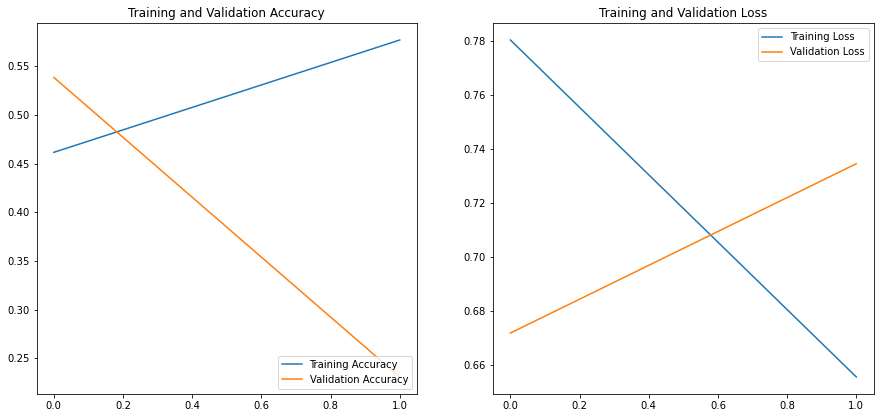

In [14]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6764047636705286
Test accuracy: 0.6470588445663452


In [16]:
#precition
predicted = model.predict(X_test)
print(predicted)

[[0.6498141  0.46104604]
 [0.5054775  0.50696075]
 [0.50964785 0.54327923]
 [0.6139039  0.5792955 ]
 [0.57701135 0.612034  ]
 [0.6160323  0.64376783]
 [0.5034324  0.49812728]
 [0.5586801  0.5004733 ]
 [0.57552856 0.53844756]
 [0.42942095 0.45551428]
 [0.5545182  0.5057401 ]
 [0.4947305  0.5577364 ]
 [0.56228095 0.5101199 ]
 [0.6644822  0.78707695]
 [0.55201    0.59563166]
 [0.5906721  0.46342838]
 [0.49356854 0.49652705]]


In [17]:
predicted = np.argmax(predicted, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [18]:
from sklearn.metrics import classification_report 
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.56      0.71      0.63         7

    accuracy                           0.65        17
   macro avg       0.65      0.66      0.65        17
weighted avg       0.67      0.65      0.65        17



In [19]:
#prediction
pred = model.predict_classes(X_test)
print(pred)

[0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 1]


In [20]:
for i in range(len(pred)):
    print("X_test=%s, class=%s, Predicted class=%s" % (i,y_test[i], pred[i]))

X_test=0, class=0, Predicted class=0
X_test=1, class=0, Predicted class=1
X_test=2, class=1, Predicted class=1
X_test=3, class=0, Predicted class=0
X_test=4, class=0, Predicted class=1
X_test=5, class=0, Predicted class=1
X_test=6, class=0, Predicted class=0
X_test=7, class=0, Predicted class=0
X_test=8, class=1, Predicted class=0
X_test=9, class=1, Predicted class=1
X_test=10, class=0, Predicted class=0
X_test=11, class=1, Predicted class=1
X_test=12, class=0, Predicted class=0
X_test=13, class=1, Predicted class=1
X_test=14, class=0, Predicted class=1
X_test=15, class=1, Predicted class=0
X_test=16, class=1, Predicted class=1
